# The Gap Statistic

In [201]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import CreateDataFunctions as df
Xdat, Ydat = df.Data1()


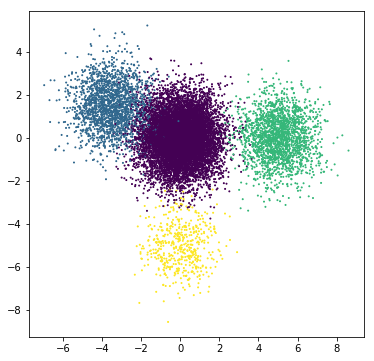

In [194]:
plt.figure(figsize=(6,6)) 
plt.scatter(Xdat[:,0],Xdat[:,1], c=Ydat,s=1) 
plt.show()

### Creating a uniform distrubution inside the boundary of the clusters

In [195]:
def bounding_box(data):
    xMin, yMin = min(data[:,0]), min(data[:,1])
    xMax, yMax = max(data[:,0]), max(data[:,1])
    return xMin,xMax, yMin, yMax

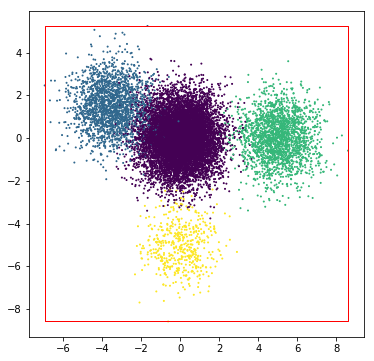

In [196]:
xMin,xMax,yMin,yMax = bounding_box(Xdat)
plt.figure(figsize=(6,6)) 
plt.plot([xMin, xMin, xMax, xMax, xMin], [yMin, yMax, yMax, yMin, yMin], linewidth=1, c='r')
plt.scatter(Xdat[:,0],Xdat[:,1], c=Ydat,s=1) 
plt.show()

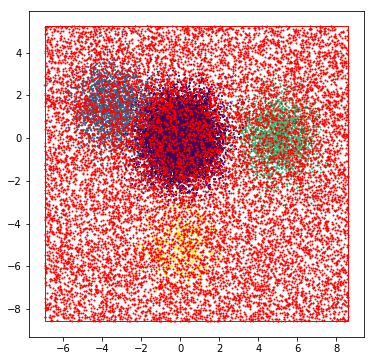

In [197]:
Random_Xdat = np.transpose(np.array([np.random.uniform(xMin,xMax,int(len(Xdat))), \
                                     np.random.uniform(yMin,yMax,int(len(Xdat)))]))
plt.figure(figsize=(6,6)) 
plt.plot([xMin, xMin, xMax, xMax, xMin], [yMin, yMax, yMax, yMin, yMin], linewidth=1, c='r')
plt.scatter(Xdat[:,0],Xdat[:,1], c=Ydat,s=1) 
plt.scatter(Random_Xdat[:,0],Random_Xdat[:,1], c='r',s=1) 
plt.show()

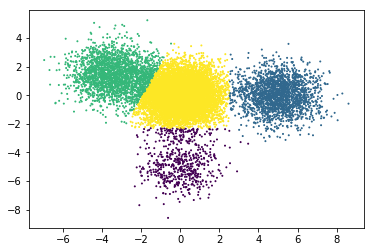

In [198]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(Xdat)
plt.scatter(Xdat[:,0],Xdat[:,1], c=kmeans.labels_,s=1) 
plt.show()

### Plot the within-cluster point scatter for K-means on the real data and uniform data

In [275]:
def withinClusterScatter(clusters, mu):
    K = len(mu)
    res = sum([np.linalg.norm(mu[i]-c)**2/(2*len(c)) \
               for i in range(K) for c in clusters[i]])
    return res

def getClustersFromKMean(labels, data, nrClusters):
    clusters = []
    
    for i in range(nrClusters):
        clusters.append(Xdat[labels == i])
        
    return clusters
    

wc_real_data = []
wc_reference_data = []
clusterSizes = 10
B = 10 # number of reference datasets

for K in range(1,11):
    
    nrDataPoints = len(Xdat)
    
    # We generate 10 reference data sets with K clusters and check Wc
    wc_bs = np.zeros(B);
    for i in range(B):
        random_Xdat = np.transpose(np.array([np.random.uniform(xMin,xMax,nrDataPoints), \
                                     np.random.uniform(yMin,yMax,nrDataPoints)]))
        
        kmeans_unif_data = KMeans(n_clusters=K, random_state=0).fit(Random_Xdat)
        clusters_unif = getClustersFromKMean(kmeans_unif_data.labels_, Random_Xdat, K);
        wc_unif = withinClusterScatter(clusters_unif, kmeans_unif_data.cluster_centers_)
        wc_bs[i] = wc_unif
    
    wc_reference_data.append(np.log(sum(wc_bs)/B))
    
    # Calculate Wc for real data
    kmeans_real_data = KMeans(n_clusters=K, random_state=0).fit(Xdat)
    clusters_real = getClustersFromKMean(kmeans_real_data.labels_, Xdat, K);
    wc_real_log = np.log(withinClusterScatter(clusters_real, kmeans_real_data.cluster_centers_))
    
    wc_real_data.append(wc_real_log)
    


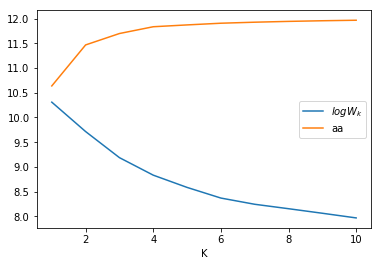

In [276]:
plt.rc('text', usetex=False)
plt.plot(range(1,11), wc_real_data, label=r"$log W_k$")
plt.plot(range(1,11), wc_reference_data, label="aa")
plt.legend(loc='center right')
plt.xlabel("K")
plt.show()
